# CNN Transfer Learning [Efficient Net]

In [1]:
!pip install git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-hk04gwaf
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-hk04gwaf
  Created wheel for efficientnet: filename=efficientnet-1.1.0-py3-none-any.whl size=18326 sha256=1001c3cdcde70c714af854c5f9d9c5be9c045569b87c6e9dcd41011b5a6e4a1c
  Stored in directory: /tmp/pip-ephem-wheel-cache-fwe_zmit/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet


In [2]:
import pandas as pd
import os

In [3]:
# directory list
train_path = '../input/kue-indonesia/train/'
test_path = '../input/kue-indonesia/test/'
validation_path = '../input/kue-indonesia/validation/'
items = os.listdir(train_path)
items

['kue_lumpur',
 'kue_risoles',
 'kue_lapis',
 'kue_dadar_gulung',
 'kue_putri_salju',
 'kue_kastengel',
 'kue_serabi',
 'kue_klepon']

In [4]:
# create items path
train_dir = []
test_dir = []
validation_dir = []
for item in items :
    train_dir.append(train_path + item + '/')
    test_dir.append(test_path + item + '/')
    validation_dir.append(validation_path + item + '/')

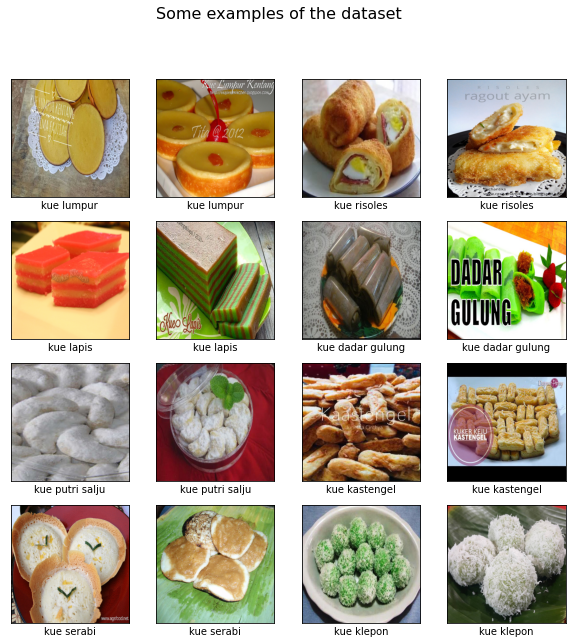

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

labels = [(" ").join(x.split('_')) for x in items]

fig = plt.figure(figsize=(10,10))
fig.suptitle("Some examples of the dataset", fontsize=16)
i = 1
for path in train_dir :
    for j in range(2) :
        img = mpimg.imread(path+os.listdir(path)[j])
        size = min(img.shape[0], img.shape[1])
        img = cv2.resize(img, (size,size))
        
        plt.subplot(4,4,i)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img, cmap=plt.cm.binary)
        plt.xlabel(labels[int((i-1)/2)])
        i += 1
plt.show()

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = train_path
train_datagen = ImageDataGenerator( rescale = 1.0/255. ,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

VALIDATION_DIR = validation_path
validation_datagen = ImageDataGenerator( rescale = 1.0/255. ,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

validation_generator = train_datagen.flow_from_directory(VALIDATION_DIR,
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))




Found 1516 images belonging to 8 classes.
Found 160 images belonging to 8 classes.


In [7]:
TEST_DIR = test_path
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150,150),
    class_mode='categorical',
    batch_size=10)

Found 160 images belonging to 8 classes.


# Define Callbacks

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

def callbacks(model_name):
    cb = []

    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                       factor=0.5, patience=1, 
                                       verbose=1, mode='min', 
                                       epsilon=0.0001, min_lr=0,
                                       restore_best_weights=True)
    cb.append(reduceLROnPlat)
    
    log = CSVLogger('log_{}.csv'.format(model_name))
    cb.append(log)
    
    es = EarlyStopping(monitor='val_loss', patience=4, verbose=0,
                       mode='min', restore_best_weights=True)
    
    cb.append(es)
    
    return cb

# EfficientNet B7

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from efficientnet.tfkeras import EfficientNetB7

pre_trained_model = EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_shape=(150, 150, 3),
    pooling='avg',
)


258441216/258434480 [==============================] - 9s 0us/step


In [10]:
for layer in pre_trained_model.layers:
    layer.trainable = False


last_layer = pre_trained_model.get_layer('avg_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (8, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

last layer output shape:  (None, 2560)


In [11]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 200,
            verbose = 1,
            callbacks = callbacks('model_efficientnetb7'))

Epoch 1/200
95/95 [==============================] - 77s 806ms/step - loss: 1.3080 - accuracy: 0.5468 - val_loss: 0.8492 - val_accuracy: 0.7125 - lr: 0.0010
Epoch 2/200
95/95 [==============================] - 66s 694ms/step - loss: 0.9621 - accuracy: 0.6807 - val_loss: 0.7631 - val_accuracy: 0.7125 - lr: 0.0010
Epoch 3/200
95/95 [==============================] - 66s 696ms/step - loss: 0.8062 - accuracy: 0.7276 - val_loss: 0.6284 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 4/200
95/95 [==============================] - ETA: 0s - loss: 0.7922 - accuracy: 0.7296
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
95/95 [==============================] - 66s 695ms/step - loss: 0.7922 - accuracy: 0.7296 - val_loss: 0.7095 - val_accuracy: 0.7688 - lr: 0.0010
Epoch 5/200
95/95 [==============================] - 67s 704ms/step - loss: 0.6951 - accuracy: 0.7737 - val_loss: 0.5600 - val_accuracy: 0.7688 - lr: 5.0000e-04
Epoch 6/200
95/95 [=============================

In [12]:
results = model.evaluate(test_generator)

16/16 [==============================] - 7s 436ms/step - loss: 0.3232 - accuracy: 0.9062


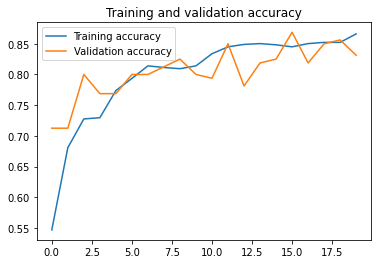

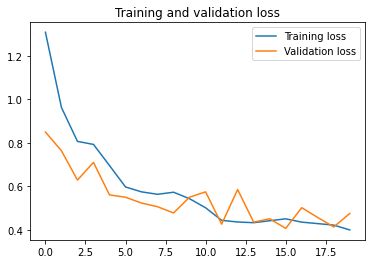

In [13]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc)) # Get number of epochs

plt.figure()
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='Training loss' )
plt.plot  ( epochs, val_loss, label='Validation loss' )
plt.title ('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [14]:
model.save_weights('model_efficientnetb7.h5')

# EfficientNet B5

In [15]:
from efficientnet.tfkeras import EfficientNetB5

pre_trained_model = EfficientNetB5(
    include_top=False,
    weights="imagenet",
    input_shape=(150, 150, 3),
    pooling='avg',
)

115515392/115515256 [==============================] - 5s 0us/step


In [16]:
for layer in pre_trained_model.layers:
    layer.trainable = False


last_layer = pre_trained_model.get_layer('avg_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (8, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

last layer output shape:  (None, 2048)


In [17]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 200,
            verbose = 1,
            callbacks = callbacks('model_efficientnetb5'))

Epoch 1/200
95/95 [==============================] - 68s 712ms/step - loss: 1.0878 - accuracy: 0.6293 - val_loss: 0.7985 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 2/200
95/95 [==============================] - 65s 688ms/step - loss: 0.7407 - accuracy: 0.7361 - val_loss: 0.6809 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/200
95/95 [==============================] - 66s 690ms/step - loss: 0.6483 - accuracy: 0.7836 - val_loss: 0.5979 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 4/200
95/95 [==============================] - ETA: 0s - loss: 0.6038 - accuracy: 0.7883
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
95/95 [==============================] - 65s 689ms/step - loss: 0.6038 - accuracy: 0.7883 - val_loss: 0.6079 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 5/200
95/95 [==============================] - 65s 685ms/step - loss: 0.5168 - accuracy: 0.8226 - val_loss: 0.4299 - val_accuracy: 0.8375 - lr: 5.0000e-04
Epoch 6/200
95/95 [=============================

In [18]:
results = model.evaluate(test_generator)

16/16 [==============================] - 7s 429ms/step - loss: 0.3253 - accuracy: 0.8938


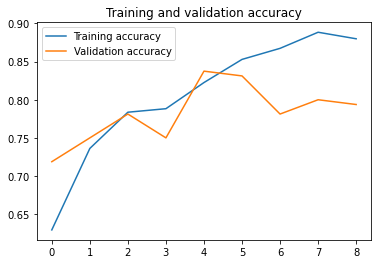

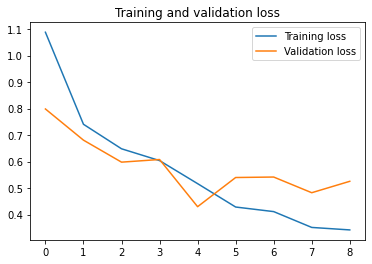

In [19]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc)) # Get number of epochs

plt.figure()
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='Training loss' )
plt.plot  ( epochs, val_loss, label='Validation loss' )
plt.title ('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [20]:
model.save("model_efficientnetb5.h5")

# EfficientNetB3

In [21]:
from efficientnet.tfkeras import EfficientNetB3

pre_trained_model = EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(150, 150, 3),
    pooling='avg',
)

44113920/44107200 [==============================] - 2s 0us/step


In [22]:
for layer in pre_trained_model.layers:
    layer.trainable = False


last_layer = pre_trained_model.get_layer('avg_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (8, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

last layer output shape:  (None, 1536)


In [23]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 200,
            verbose = 1,
            callbacks = callbacks('model_efficientnetb3'))

Epoch 1/200
95/95 [==============================] - 66s 692ms/step - loss: 0.9196 - accuracy: 0.6906 - val_loss: 0.6441 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 2/200
95/95 [==============================] - 63s 666ms/step - loss: 0.5642 - accuracy: 0.8041 - val_loss: 0.4745 - val_accuracy: 0.8562 - lr: 0.0010
Epoch 3/200
95/95 [==============================] - 64s 672ms/step - loss: 0.4222 - accuracy: 0.8602 - val_loss: 0.4218 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 4/200
95/95 [==============================] - 64s 669ms/step - loss: 0.3828 - accuracy: 0.8654 - val_loss: 0.3411 - val_accuracy: 0.8687 - lr: 0.0010
Epoch 5/200
95/95 [==============================] - ETA: 0s - loss: 0.3398 - accuracy: 0.8773
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
95/95 [==============================] - 62s 656ms/step - loss: 0.3398 - accuracy: 0.8773 - val_loss: 0.4553 - val_accuracy: 0.8375 - lr: 0.0010
Epoch 6/200
95/95 [==============================] -

In [24]:
results = model.evaluate(test_generator)

16/16 [==============================] - 7s 408ms/step - loss: 0.2632 - accuracy: 0.9187


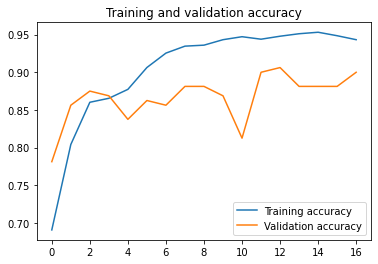

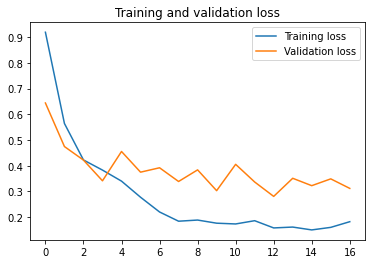

In [25]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc)) # Get number of epochs

plt.figure()
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='Training loss' )
plt.plot  ( epochs, val_loss, label='Validation loss' )
plt.title ('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [26]:
model.save_weights('model_efficientnetb3.h5')